In [141]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [142]:
fs, p = wavfile.read('sonido-presion/presion_segmento_3.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_3.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_3.wav')
fs, delta = wavfile.read('sonido-presion/delta_segmento_3.wav')

In [143]:
import json
t_silabas_file = open('sonido-presion/t_silabas.json') 

# returns JSON object as a list 
t_silabas = json.load(t_silabas_file) ['segmento_3']

In [144]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4  #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [145]:
#preguntar las ci !!!
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0

In [146]:
dt_m = 1/fs
N  = len(p)
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.5542695356738392 s


In [147]:
#dt = 1/884000
dt = dt_m / 20
t = np.arange(0, t_m[-1] + dt_m, dt)

In [148]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')
len(t)

N de la simulacion: 489441 
 N de los datos 24472 
  Tomo de la simulación 1 dato cada 20.000040863027134


489441

In [149]:
#inrepolo p

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))

#interpolo delta
interp_func2 = interp1d(t_m, delta)

delta_interp = interp_func2(np.linspace(0, t_m[-1],len(t) ))

In [171]:
#sumo ruido
sigma_s = np.std(s_m[(p + 0.39)<0]/max(s_m))
ruido = np.random.normal(0, sigma_s, len(t))

N_i = len(t)

#normalizo y offset de beta
offset = 0.39
b_int = (b_interpolado/max(b_interpolado)) + offset 

Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0



In [151]:
# Integración: le agrego el ruido a f0 para 

for j in range(N_i):
    params = [4, c, delta_interp[j] *4 + ruido[j]*5, b_int[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    

In [152]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
#plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t,Xs[:,0][:-1]/ max(Xs[:,0][:-1]),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) ,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_/ max(b_),alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
#plt.xlim(0.22,0.29)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$\omega(t)$', fontsize=16)


plt.suptitle(r"Evolución del sistema con $\beta$ de mediciones y $\delta$ construido")

Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones y $\\delta$ construido')

### Espectrograma

In [153]:
def get_spectrogram(data, sampling_rate, window=1024, overlap=1/1.1,
                    sigma=102.4, fmax=8000, drange=6):
    fu, tu, Sxx = signal.spectrogram(data, sampling_rate, nperseg=window,
                                     noverlap=window*overlap,
                                     window=signal.get_window
                                     (('gaussian', sigma), window),
                                     scaling='spectrum')
    Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/10**drange, a_max=np.amax(Sxx))
    return fu, tu, Sxx

In [154]:
import matplotlib.colors as mcolors
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)


In [ ]:
t_pulsos = [[np.float64(0.002740656851642129), np.float64(0.07297848244620611)] ,
[np.float64(0.09413363533408833), np.float64(0.16573046432616081)] ,
[np.float64(0.18892412231030578), np.float64(0.25977349943374856)] ,
[np.float64(0.2782106455266138), np.float64(0.3493318233295583)] ,
[np.float64(0.3673839184597961), np.float64(0.4409739524348811)] ,
[np.float64(0.4594337485843714), np.float64(0.5371913929784824)]]


In [155]:
k = np.ones(N_i)
f0 = np.ones(N_i)
for i,sil in enumerate(t_silabas):
    ti = t_silabas[sil]['t_i']
    tf = t_silabas[sil]['t_f']

    #index
    index_i = np.where(t > ti)[0][0]
    index_f = np.where(t > tf)[0][0]
    ks_new =  np.linspace(2,4,int(index_f - index_i))
    f0_new = 5
    
    k[index_i : index_f] = ks_new
    f0[index_i : index_f] = f0_new

In [156]:
k_ = k
#condiciones iniciales 
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
#integro
for j in range(N_i):
    params = [k_[j], c, (delta_interp[j]  + ruido[j]) * f0[j], b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

#espextrograma simulacion
fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

#colormap
colors = [(0,0.1 * i,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = ['green','red','black','blue']



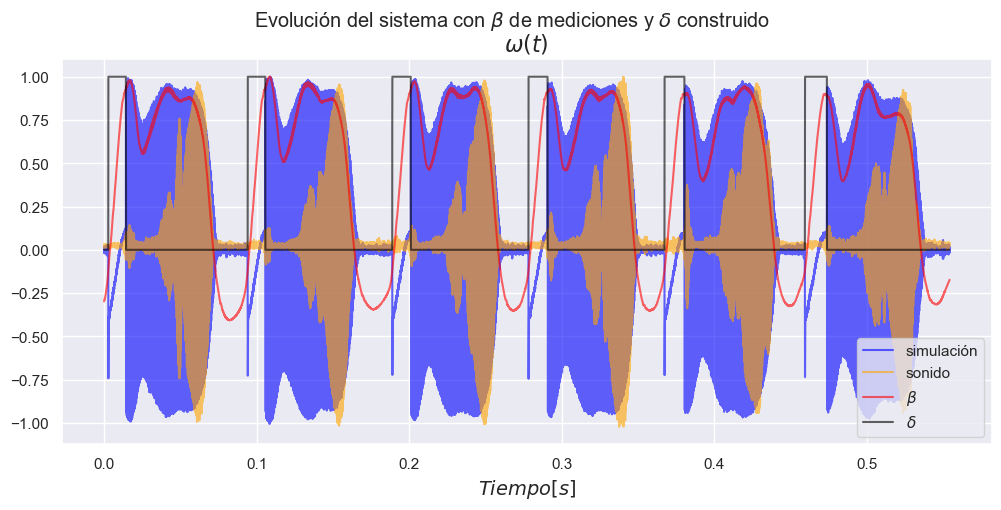

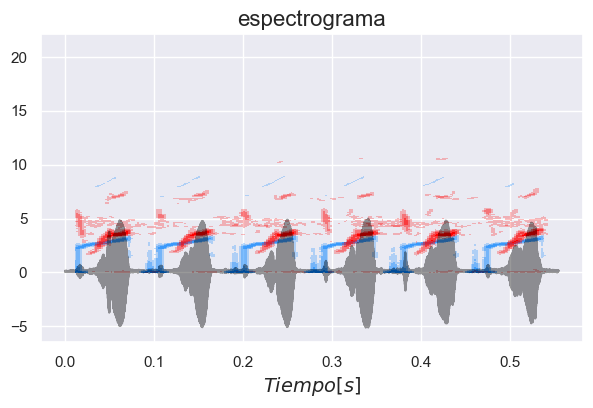

In [157]:

#ploteo espectrograma
plt.figure(figsize=(7,4))
plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue)
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred)
plt.plot(t_m,s_m/max(s_m)* 5, color = 'black', alpha = .4)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'espectrograma', fontsize=16)
plt.show()

Veamos cómo modifico los parámetros de la simulación para que la frecuencia principal se parezca más a la del sonido. 
Conversación con Facu: vs está medido desde uno de los lados de la bifuración de la siringe (preguntar una palabra más técnica). 
Cada lado produce un sonido con distinta frecuencia (preguntar, pero por lo que entiendo de uno la frecuencia ppal es menor a 6.5khz y y la otra mayor a eso).

Para el segmento 3 la frecuencia principal de cada silaba se divide en 3 partes: 
La primera creo que es de la segunda siringe 
Las dos segunda son de la primer siringe pero tienen pendientes distintas. 

Cómo detecto el momento en el que cambian las frecuencias principales? Analizo el espectrograma del sonido

In [ ]:
print(tu.shape, fu.shape, Sxx.shape)

#### Separo los pulsos

In [158]:
dt_ = 1/fs
N  = len(b)
t_ = np.arange(0, N) * dt_

12
[121, 3223, 4156, 7318, 8341, 11470, 12283, 15424, 16220, 19470, 20284, 23718]
[121, 3223, 4156, 7318, 8341, 11470, 12283, 15424, 16220, 19470, 20284, 23718]


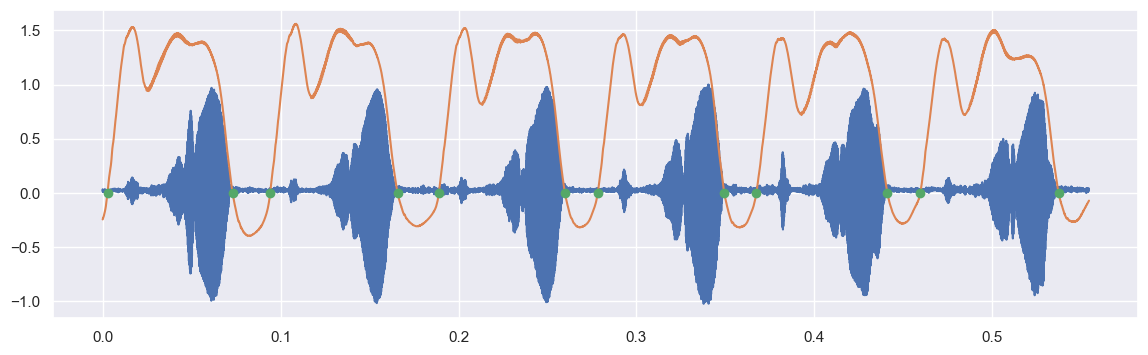

In [159]:
index_split = []
for i in range(len(t_)-1):
    if b[i]*b[i+1] < 0:
        #print(f'Cambio de signo en t= {t[i]}')
        index_split.append(i)
print(len(index_split))
print(index_split)

print(index_split)

plt.figure(figsize=(14,4))
plt.plot(t_[:-1],s_m/max(s_m))
plt.plot(t_,b)
plt.plot(t_[index_split], b[index_split], 'o')
plt.show()

In [160]:
#ordeno los datos

pulsos = {i: {'t' : t_[index_split[i]:index_split[i+1]],
              's_m': s_m[index_split[i]:index_split[i+1]],
              'b': b[index_split[i]:index_split[i+1]]} for i in range(12) if i%2==0 } 
print(len(pulsos))

6


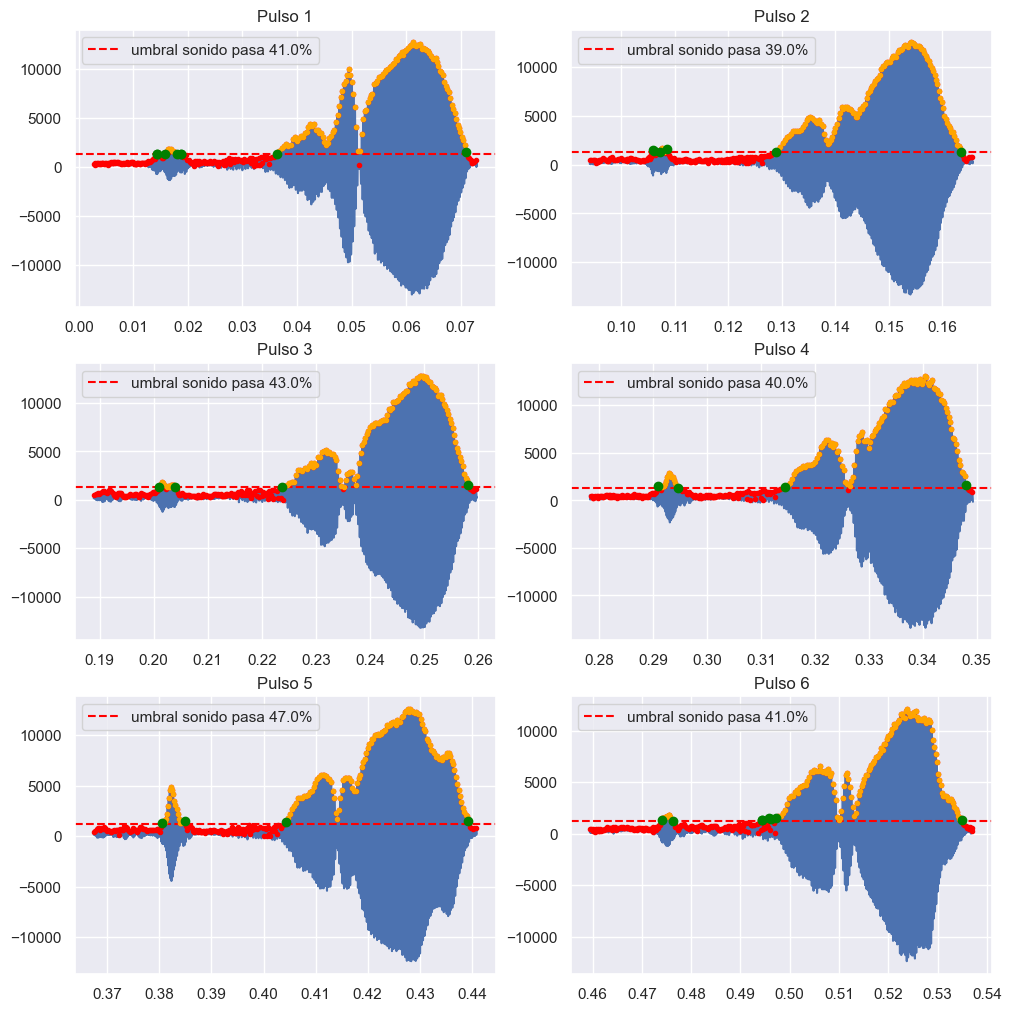

In [163]:
fig, axes = plt.subplots(3, 2, figsize=(10,10), constrained_layout=True, sharex=False)
axs = axes.flatten()
ts_ = t_
for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_m_ = pulsos[ps]['s_m'] 
    picos_m, _ = signal.find_peaks(s_m_, height = 0 )  

    umbral_m = max(s_m_) * .1

    #indices de los picos que pasan el umbral
    index_fon_m = [pm for pm in picos_m if s_m_[pm] > umbral_m]

    #fraccion de los picos que pasan el umbral
    fon_m = len(index_fon_m)/ len(picos_m)

    #indices de los intervalos de fonacion (criterio: que no sean consecutivos)
    index_intervalo_fon_m = [index_fon_m[0]]
    tresh = max(np.diff(picos_m)) * 1.7 # criterio para determnar si los picos son consecutivos o no
    for j in range(len(index_fon_m)):
        if index_fon_m[j] - index_fon_m[j-1] > tresh:
            index_intervalo_fon_m.append(index_fon_m[j])
        if j < len(index_fon_m)-1:
            if index_fon_m[j+1] - index_fon_m[j] > tresh:
                index_intervalo_fon_m.append(index_fon_m[j])
    index_intervalo_fon_m.append(index_fon_m[-1])
    
    axs[i].plot(t_,s_m_) #, label = 'sonido')
    axs[i].axhline( umbral_m,label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'red', ls = '--')
    #axs[i].plot(t_, umbral_s, label = f'umbral sim: pasa {np.round(fon_s*100)}%', color = 'blue', ls = '--')
    #axs[i].plot(t_, umbral_m, label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'orange', ls = '--')
    axs[i].plot(t_[picos_m], s_m_[picos_m], '.', color = 'red')
    axs[i].plot(t_[index_fon_m], s_m_[index_fon_m], '.', color = 'orange')
    axs[i].plot(t_[index_intervalo_fon_m] , s_m_[index_intervalo_fon_m] , 'o', color = 'green')
    #axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()
plt.show()

In [164]:

%matplotlib qt

#plt.switch_backend('QtAgg4')
for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    picos, _ = signal.find_peaks(s_m_)  

    plt.figure()
    plt.plot(t_,s_m_, label = 'sonido')
    x = plt.ginput(5)
    pulsos[ps]['int_fon'] = x

In [165]:
print(pulsos[ps]['int_fon'])

[(np.float64(0.4721007196872831), np.float64(337.72857142857174)), (np.float64(0.47934346801592814), np.float64(337.72857142857174)), (np.float64(0.49538098217221355), np.float64(337.72857142857174)), (np.float64(0.5114184963284989), np.float64(264.880357142858)), (np.float64(0.5365956690899792), np.float64(410.5767857142855))]


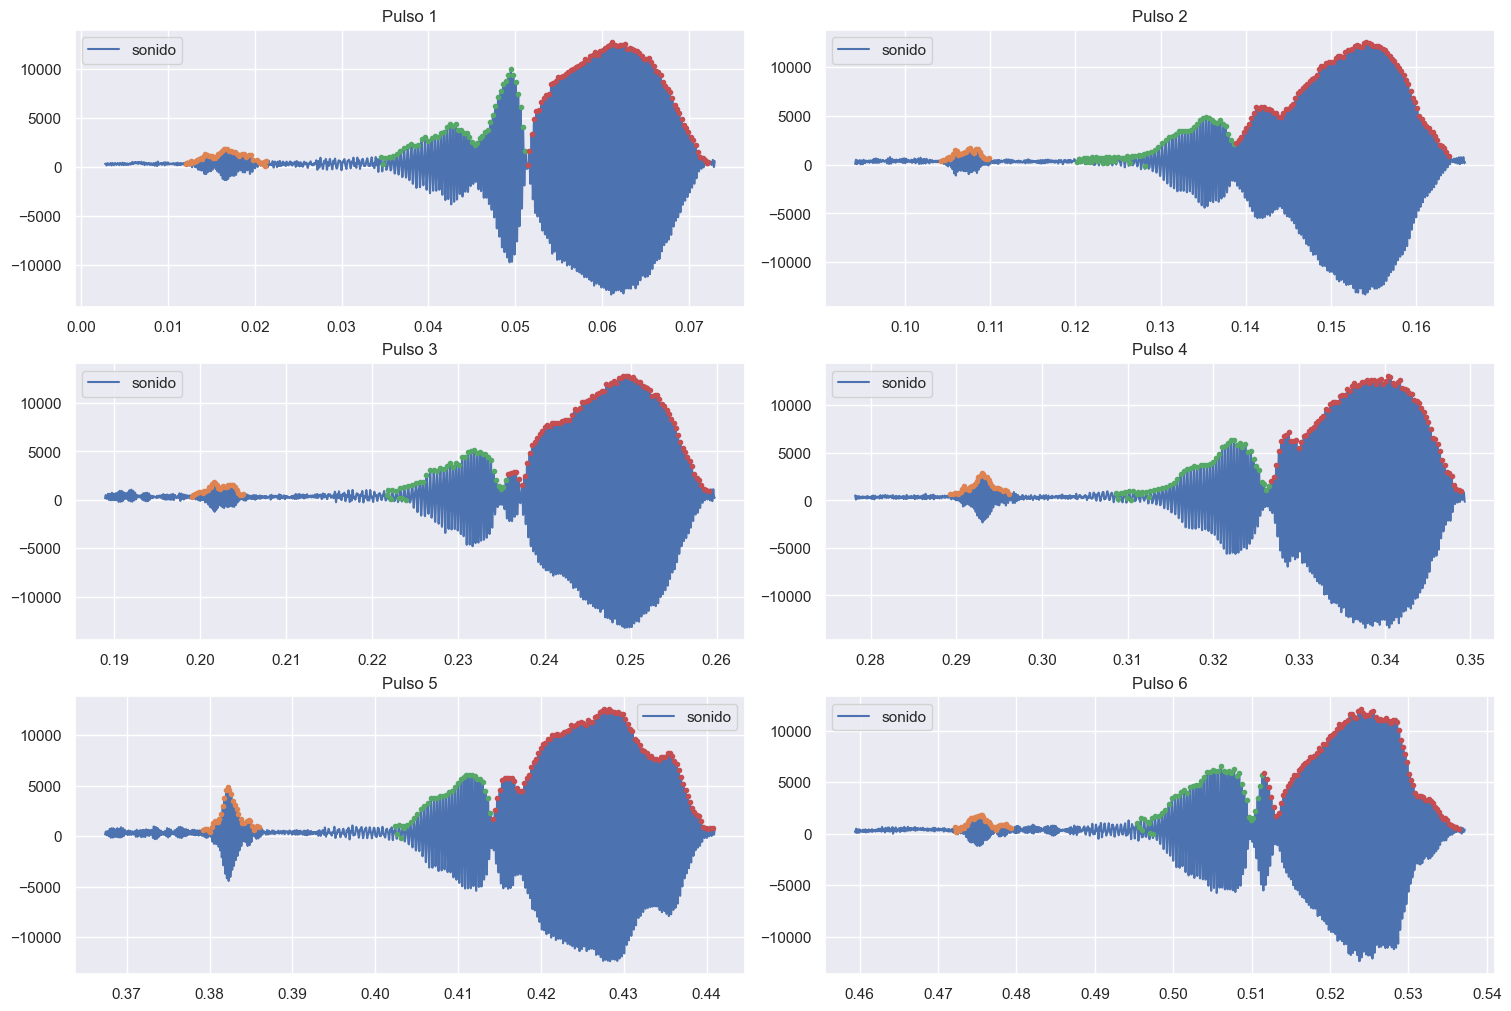

In [166]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, figsize=(15,10), constrained_layout=True, sharey=False)
axs = axes.flatten()


for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    #los tres subintervalos donde la frecuencia principal tiene un patron distinto
    t_1_i = pulsos[ps]['int_fon'][0][0]
    t_1_f = pulsos[ps]['int_fon'][1][0]

    t_2_i = pulsos[ps]['int_fon'][2][0]
    t_2_f = pulsos[ps]['int_fon'][3][0]

    t_3_i = pulsos[ps]['int_fon'][3][0]
    t_3_f = pulsos[ps]['int_fon'][4][0]

    
    picos, _ = signal.find_peaks(s_m_)  

    #guardo los indices de los picos
    pulsos[ps]['picos_m'] = picos
    
    #print(len(picos_m), len(dist_picos))

    index_1 = picos[t_1_i < t_[picos] ]
    index_1 = index_1[ t_[index_1] < t_1_f]

    index_2 = picos[t_2_i < t_[picos] ]
    index_2 = index_2[ t_[index_2] < t_2_f]

    index_3 = picos[t_3_i < t_[picos] ]
    index_3 = index_3[ t_[index_3] < t_3_f]
    

    #axs[i].plot(t_[picos][1:-2],np.abs(dif_dif)*1e4, label = 'diferencia de dist')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].plot(t_[index_1],s_m_[index_1], '.')
    axs[i].plot(t_[index_2],s_m_[index_2], '.')
    axs[i].plot(t_[index_3],s_m_[index_3], '.')
    #axs[i].plot(t_[index_dif_dif_fon],s_m_[index_dif_dif_fon], '.', label = 'fonacion promedio')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()
plt.show()

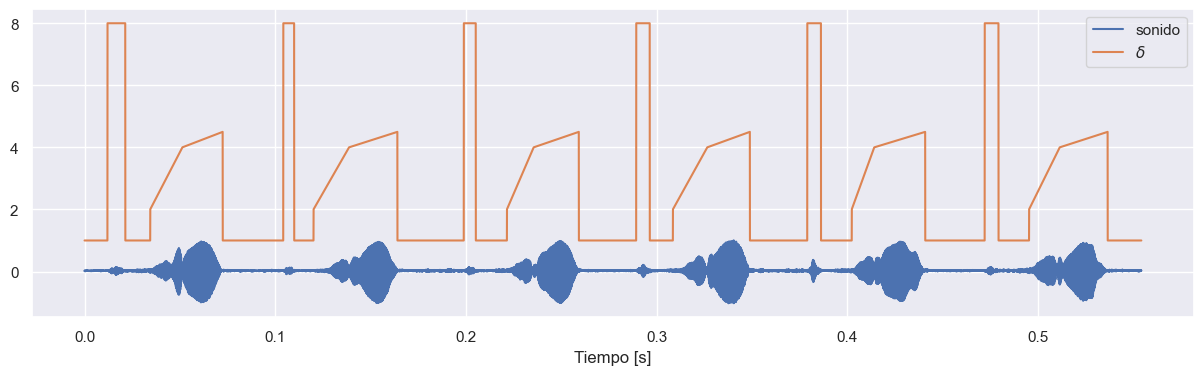

In [167]:
%matplotlib inline

k = np.ones(len(t))
f0 = np.ones(len(t))

for ps in pulsos:
    t_ = pulsos[ps]['t']
    picos = pulsos[ps]['picos_m']

    #los tres subintervalos donde la frecuencia principal tiene un patron distinto
    t_1_i = pulsos[ps]['int_fon'][0][0]
    t_1_f = pulsos[ps]['int_fon'][1][0]

    t_2_i = pulsos[ps]['int_fon'][2][0]
    t_2_f = pulsos[ps]['int_fon'][3][0]

    t_3_i = pulsos[ps]['int_fon'][3][0]
    t_3_f = pulsos[ps]['int_fon'][4][0]

    #indice final e inicial
    index_1_i = np.where(t > t_1_i)[0][0]
    index_1_f = np.where(t > t_1_f)[0][0]

    index_2_i = np.where(t > t_2_i)[0][0]
    index_2_f = np.where(t > t_2_f)[0][0]

    index_3_i = np.where(t > t_3_i)[0][0]
    index_3_f = np.where(t > t_3_f)[0][0]

    k[index_1_i : index_1_f] = 8
    k[index_2_i : index_2_f] = np.linspace(2,4,int(index_2_f - index_2_i))
    k[index_3_i : index_3_f] = np.linspace(4,4.5,int(index_3_f - index_3_i))

#delta[b<0] = 0
plt.figure(figsize = (15,4))
plt.xlabel('Tiempo [s]')
plt.plot(t_m,s_m/max(s_m), label = 'sonido')
plt.plot(t,k, label = r'$\delta$')

#plt.xlim(0.35, 0.7)
plt.legend()
plt.show()

In [170]:
len(b_)

3434

In [172]:
k_ = k
#condiciones iniciales 
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
#integro
for j in range(N_i):
    params = [k_[j], c, (delta_interp[j]  + ruido[j]) * f0[j], b_int[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)

#espextrograma simulacion
fu_s, tu_s, Sxx_s = get_spectrogram(Xs[:,0][::20], 44150)
Sxx_s = np.clip(Sxx_s, a_min=np.amax(Sxx_s)/20000000, a_max = np.amax(Sxx_s))

#colormap
colors = [(0,0.1 * i,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = ['green','red','black','blue']



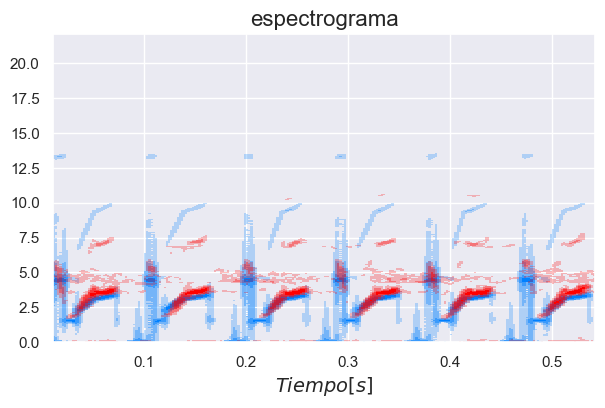

In [173]:

#ploteo espectrograma
plt.figure(figsize=(7,4))
plt.pcolormesh(tu_s, fu_s/1000, np.log(Sxx_s), rasterized=True, shading='auto', cmap=cmapblue)
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred)
#plt.plot(t_m,s_m/max(s_m)* 5, color = 'black', alpha = .4)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'espectrograma', fontsize=16)
plt.show()

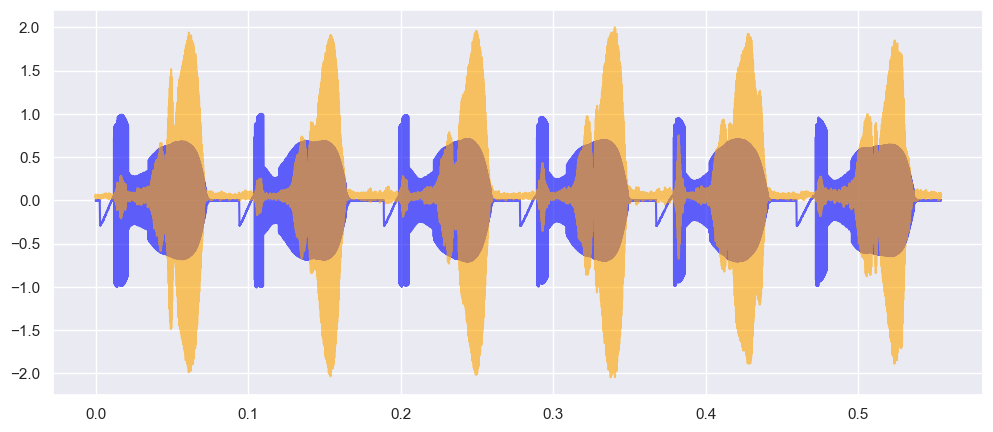

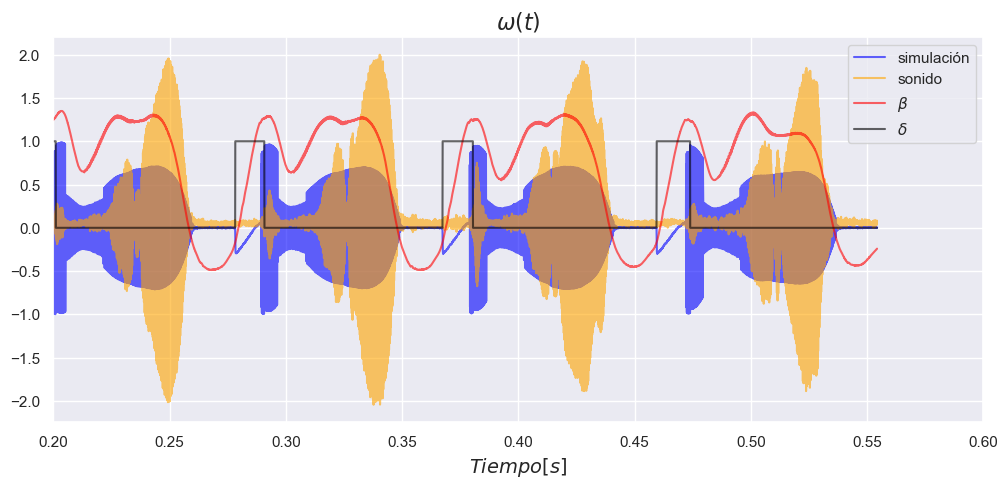

In [175]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
plt.plot(t,Xs[:,0][:-1] / max(Xs[:,0]),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_int,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.2,0.6)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$\omega(t)$', fontsize=16)
plt.show()

In [176]:
def y(w,x, beta):
    mu = 1e5
    return w - mu * (x**3/3 - beta * x )

489442 489442 3434


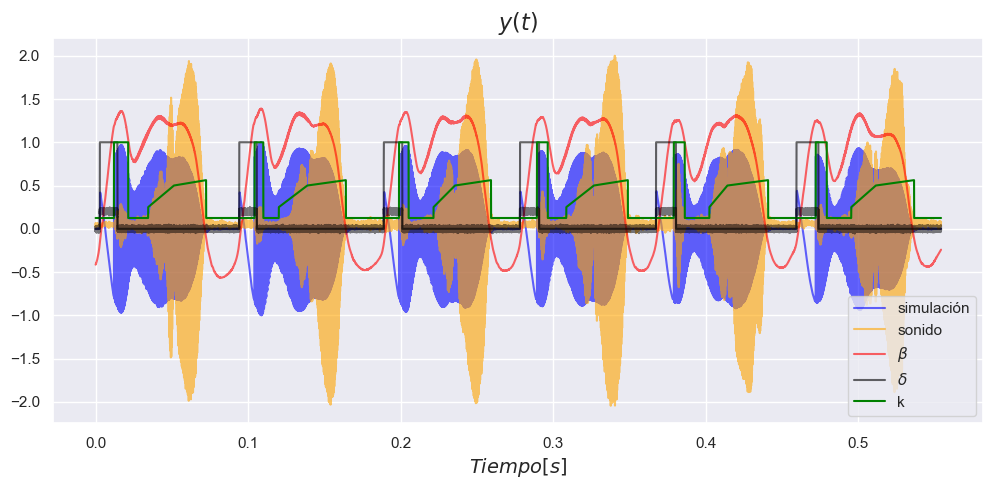

In [180]:
%matplotlib inline
plt.figure( figsize=(12,5))
#ploteo
colors = ['green','red','black','blue']
print(len(Xs[:,0]),len(Xs[:,1]), len(b_))
y_ = y(Xs[:,0][:-1],Xs[:,1][:-1], b_int)
plt.plot(t,y_/max(y_),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_int,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k_/max(k_), color = 'green', label = 'k')
plt.plot(t,( (delta_interp  + ruido) * f0)/5, color = 'black', alpha = .5)
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
#plt.xlim(0.2,0.7)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.show()

In [181]:
wavfile.write("sonido-presion/y_segmento_3.wav", fs, y_[::20].astype(np.float32))
wavfile.write("sonido-presion/k_segmento_3.wav", fs, k_[::20].astype(np.float32))